In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
from evaluation import Evaluation

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from numpy import dot
from numpy.linalg import norm

import nltk, json, re, codecs,operator,requests
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

stoppy = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
evaluator = Evaluation()

In [5]:
def preproc(dic):
  dic_1={}
  for tit,artic in dic.items():
      tokens = []
      for i in sent_tokenize(artic):
          for j in word_tokenize(i):
              if j not in stoppy:
                tokens.extend(re.split(r"['-/=]", j))
      tokens = [stemmer.stem(word) for word in tokens if word not in ['=','?', ':', '!', '.', ',', ';','',' ']]
      dic_1[tit] = [lemmatizer.lemmatize(r) for r in tokens]
  return dic_1

def cosine_similarity(x,y):
  d = norm(x)*norm(y)
  if d == 0:
    return 0
  return dot(x,y)/d

def results(doc_IDs_ordered):
  # Calculate precision, recall, f-score, MAP and nDCG for k = 1 to 10
  precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

  for k in range(1, 11):
      precision = evaluator.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
      precisions.append(precision)
      recall = evaluator.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
      recalls.append(recall)
      fscore = evaluator.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
      fscores.append(fscore)
      
      print("Precision, Recall and F-score @ " +  str(k) + " : " + str(precision) + ", " + str(recall) + ", " + str(fscore))
      
      MAP = evaluator.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
      MAPs.append(MAP)
      nDCG = evaluator.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
      nDCGs.append(nDCG)
      print("MAP, nDCG @ " +  
          str(k) + " : " + str(MAP) + ", " + str(nDCG))
      # Plot the metrics and save plot 
  plt.figure(figsize=(10,8))
  plt.plot(range(1, 11), precisions, label="Precision")
  plt.plot(range(1, 11), recalls, label="Recall")
  plt.plot(range(1, 11), fscores, label="F-Score")
  plt.plot(range(1, 11), MAPs, label="MAP")
  plt.plot(range(1, 11), nDCGs, label="nDCG")
  plt.legend()
  plt.title("Evaluation Metrics - Cranfield Dataset")
  plt.xlabel("k")
  plt.savefig("eval_plot.png")



In [7]:
with open('cran_docs.json') as f:    #Read docs
  docs = json.load(f)
with open('cran_queries.json') as f: #Read queries
  queries = json.load(f)
with open('cran_qrels.json') as f:   #Read relevance judements
  qrels = json.load(f)

docy = {} 
for i,body in enumerate([item["body"] for item in docs]):
  docy[i+1] = body

queryy = {}
for i,q in enumerate([qry["query"] for qry in queries]):
  queryy[i+1] = q

query_ids = list(queryy.keys())
processedQueries = preproc(queryy)
processedDocs = preproc(docy)


In [11]:
types_doc = []

for doc in processedDocs.values():
    for word in doc:
        if word not in types_doc: 
            types_doc.append(word)

print("Number of types in Cranfield dataset = ",len(types_doc))

types_qry = []
for doc in processedQueries.values():
    for word in doc:
        if word not in types_qry: 
            types_qry.append(word)

print("Number of types in Cranfield queries = ",len(types_qry))

new_types = set(types_qry)-set(types_doc)
print("Number of types in queries but not in the dataset = ", len(new_types))
print("Mentionably, ",new_types)

Number of types in Cranfield dataset =  4684
Number of types in Cranfield queries =  702
Number of types in queries but not in the dataset =  14
Mentionably,  {'orthodox', 'unnecessarili', 'el', 'multhopp', 'anyon', 'empti', 'magneticfield', 'ca', 'realiti', 'stop', 'wild', 'trust', 'virtu', 'stabilityproblem'}


In [12]:
L = len(types_doc)
D = len(processedDocs)

TD_matrix = np.zeros([L,D]) # term-document matrix
                            # At the end
                            # each column of this matrix will be the TD-IDF vector representation of the corresponding document

for col, doc in processedDocs.items():                  # iterating over documents
    for word in doc:
        row = types_doc.index(word)
        TD_matrix[row,col-1] += 1

df = np.sum(TD_matrix > 0, axis=1)     # sum across rows over the Boolean matrix
                                        # document frequency for each type in cranfield dataset 

IDF = np.log(D/df)

for i in range(L):
    TD_matrix[i,:] *= IDF[i]   

# Dictionary in which key:value ==> doc_ID:Corresponding TD-IDF vector representation
index_doc = {doc_id:vector for (doc_id,vector) in zip(processedDocs.keys(),TD_matrix.transpose())}  


In [13]:
Q = len(queries)
TQ_matrix = np.zeros([L,Q]) 
for col, query in processedQueries.items():                  # iterating over documents
    for word in query:
      try:
        row = types_doc.index(word)
        TQ_matrix[row,col-1] += 1
      except:
        pass

for col in range(Q):
  for q in processedQueries[col+1]:
    try:
      row = types_doc.index(q)    
      TQ_matrix[row,col] = IDF[row]*TQ_matrix[row,col]
    except:
      pass

100%|██████████| 225/225 [00:57<00:00,  3.89it/s]


Precision, Recall and F-score @ 1 : 0.6311111111111111, 0.1058081315820435, 0.17426116719793874
MAP, nDCG @ 1 : 0.1058081315820435, 0.5166666666666667
Precision, Recall and F-score @ 2 : 0.5377777777777778, 0.1775417907954971, 0.25022228999108204
MAP, nDCG @ 2 : 0.1687931979328691, 0.48474939590383215
Precision, Recall and F-score @ 3 : 0.482962962962963, 0.2285454614064131, 0.2877105467591824
MAP, nDCG @ 3 : 0.209730216636404, 0.46181068387573715
Precision, Recall and F-score @ 4 : 0.43, 0.26325155400662337, 0.3017561425688163
MAP, nDCG @ 4 : 0.23298858629869515, 0.4489841359221508
Precision, Recall and F-score @ 5 : 0.4, 0.30056389371369996, 0.3167752280573656
MAP, nDCG @ 5 : 0.25240345771707534, 0.44686324203330413
Precision, Recall and F-score @ 6 : 0.37037037037037046, 0.3329352224700861, 0.3233105976791096
MAP, nDCG @ 6 : 0.2678790414493641, 0.4496257071761475
Precision, Recall and F-score @ 7 : 0.34476190476190516, 0.3565680829780757, 0.32365600593526356
MAP, nDCG @ 7 : 0.279504

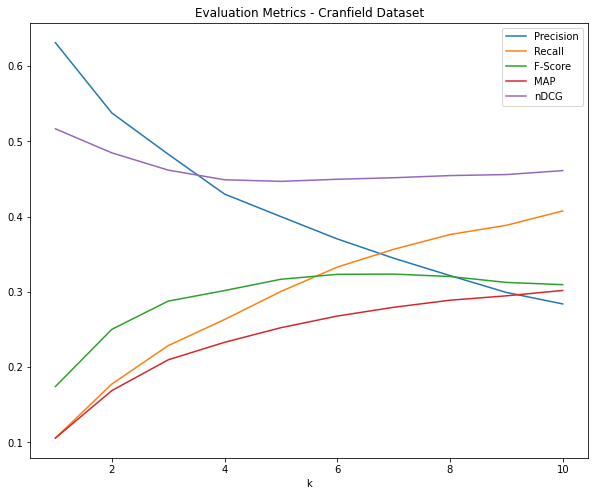

In [14]:
doc_IDs_ordered  = []

for j in tqdm(range(Q)):
  cos_sim = {}
  for doc_id, doc_vector in index_doc.items():
      cos_sim[doc_id] = cosine_similarity(doc_vector,TQ_matrix[:,j])
  doc_IDs_ordered.append([x for x, _ in sorted(cos_sim.items(),key = operator.itemgetter(1),reverse = True)])

results(doc_IDs_ordered)

Word2vec


In [15]:
import gensim.models

class MyCorpus:
  def __iter__(self):
      for doc in processedDocs.values():
        yield doc
sentences = MyCorpus()

In [16]:
model = gensim.models.Word2Vec(sentences, min_count=1,size= 700,workers=4, window =3, sg =1);

In [17]:
mostSim = {term:model.wv.most_similar(term)[:5] for term in types_qry if term in types_doc}
def queryEx_w2v(processedQueries,mostSim,weight):
  wr_dic = {}; expanded_query = {}
  for q_id,qry in processedQueries.items():
    sim_dic = {}; expanded = qry.copy();
    for q in qry:
      sim_dic[q] = 1
      try:
        for i in mostSim[q]:
          if i[0] not in expanded:
            expanded.append(i[0])
            #sim_dic[i[0]] = i[1] #watch out
            sim_dic[i[0]] = weight
      except KeyError:
        pass
    
    expanded_query[q_id] = expanded
    wr_dic[q_id] = sim_dic
  return expanded_query, wr_dic

In [18]:
exQ_w2v, wrD_w2v = queryEx_w2v(processedQueries,mostSim,0.1)

In [19]:
TQ_matrix_w2v = np.zeros([L,Q])
for col, query in exQ_w2v.items():                  # iterating over documents
    for word in query:
      try:
        row = types_doc.index(word)
        TQ_matrix_w2v[row,col-1] += 1
      except:
        pass

for col in range(Q):
  weights = wrD_w2v[col+1]
  for q in exQ_w2v[col+1]:
    try:
      row = types_doc.index(q)    
      TQ_matrix_w2v[row,col] = weights[q]*IDF[row]*TQ_matrix_w2v[row,col]
    except:
      pass

100%|██████████| 225/225 [01:04<00:00,  3.50it/s]


Precision, Recall and F-score @ 1 : 0.6222222222222222, 0.10412640200557709, 0.171509844446616
MAP, nDCG @ 1 : 0.10412640200557709, 0.5111111111111111
Precision, Recall and F-score @ 2 : 0.5377777777777778, 0.1784298204358487, 0.2513811969786784
MAP, nDCG @ 2 : 0.16812230501429815, 0.48335116712726456
Precision, Recall and F-score @ 3 : 0.48592592592592593, 0.22796928060216212, 0.28824930429793993
MAP, nDCG @ 3 : 0.2073950184350207, 0.46240265811762793
Precision, Recall and F-score @ 4 : 0.4388888888888889, 0.26660135235642174, 0.3067400809253037
MAP, nDCG @ 4 : 0.23246292156254714, 0.4511158973463217
Precision, Recall and F-score @ 5 : 0.40355555555555567, 0.3017396500561231, 0.31891504756973416
MAP, nDCG @ 5 : 0.25115298692278787, 0.4489899277416753
Precision, Recall and F-score @ 6 : 0.3718518518518518, 0.333053695850561, 0.3243542940094903
MAP, nDCG @ 6 : 0.267361714590666, 0.4500717224429754
Precision, Recall and F-score @ 7 : 0.34603174603174647, 0.3596589511742072, 0.32596146034

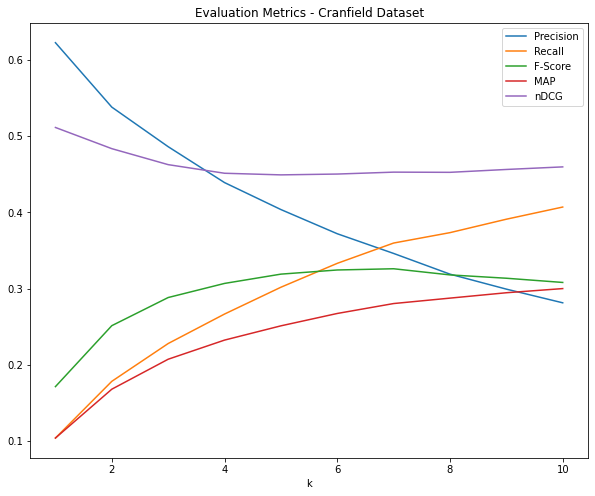

In [20]:
doc_IDs_ordered_w2v  = []

for j in tqdm(range(Q)):
  cos_sim = {}
  for doc_id, doc_vector in index_doc.items():
      cos_sim[doc_id] = cosine_similarity(doc_vector,TQ_matrix_w2v[:,j])
  doc_IDs_ordered_w2v.append([x for x, _ in sorted(cos_sim.items(),key = operator.itemgetter(1),reverse = True)])

results(doc_IDs_ordered_w2v)

In [27]:
doc_IDs_ordered_w2v[2][0:10]

[485, 5, 90, 91, 144, 582, 399, 181, 6, 579]